In [23]:
import os
from pathlib import Path

# Met ce chemin sur la racine de ton projet (là où il y a /scr et /data)
PROJECT_ROOT = Path().resolve()  # souvent ok dans VSCode
os.chdir(PROJECT_ROOT)

print("CWD =", Path().resolve())
print("scr exists:", Path("scr").exists())
print("data exists:", Path("data").exists())


CWD = /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook
scr exists: True
data exists: True


[DAG] generating…
[DAG] saved → outputs/figures_simple_reg/dag_price_demand.png
[DAG] done.
[DATA] Loading data/merged_air_travel_data.csv ...
[DATA] Cleaned merged_air_travel_data: 118035 rows.


/Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/scr/simple_regression.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


[DATA] Aggregated panel (state → city → year) ready: 24932 observations.

[STATES] Running OLS (levels) with clustered SE (groups = route_id)

=== [STATES] OLS levels (total_passengers ~ avg_price) ===
                            OLS Regression Results                            
Dep. Variable:       total_passengers   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.5430
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.462
Time:                        17:55:55   Log-Likelihood:                -54633.
No. Observations:                5044   AIC:                         1.093e+05
Df Residuals:                    5042   BIC:                         1.093e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
        

<Figure size 640x480 with 0 Axes>

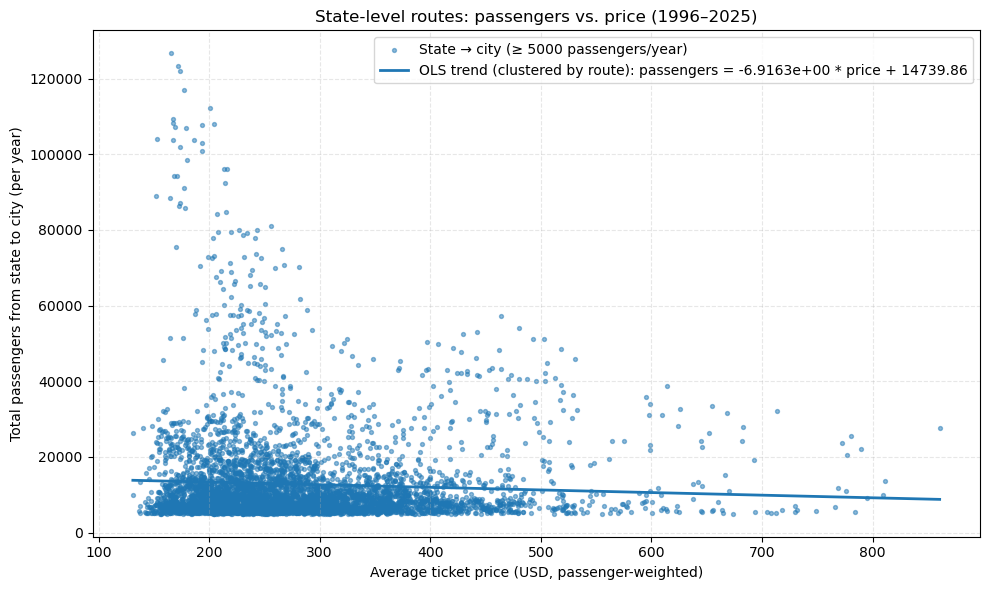

[PLOT] saved → outputs/figures_simple_reg/routes_states_price_x.png


/Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/scr/simple_regression.py:232: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({



[CITIES] Running OLS (levels) with clustered SE (groups = route_id)

=== [CITIES] OLS levels (total_passengers ~ avg_price) ===
                            OLS Regression Results                            
Dep. Variable:       total_passengers   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                    0.6054
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.437
Time:                        17:56:00   Log-Likelihood:                -48371.
No. Observations:                4586   AIC:                         9.675e+04
Df Residuals:                    4584   BIC:                         9.676e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--

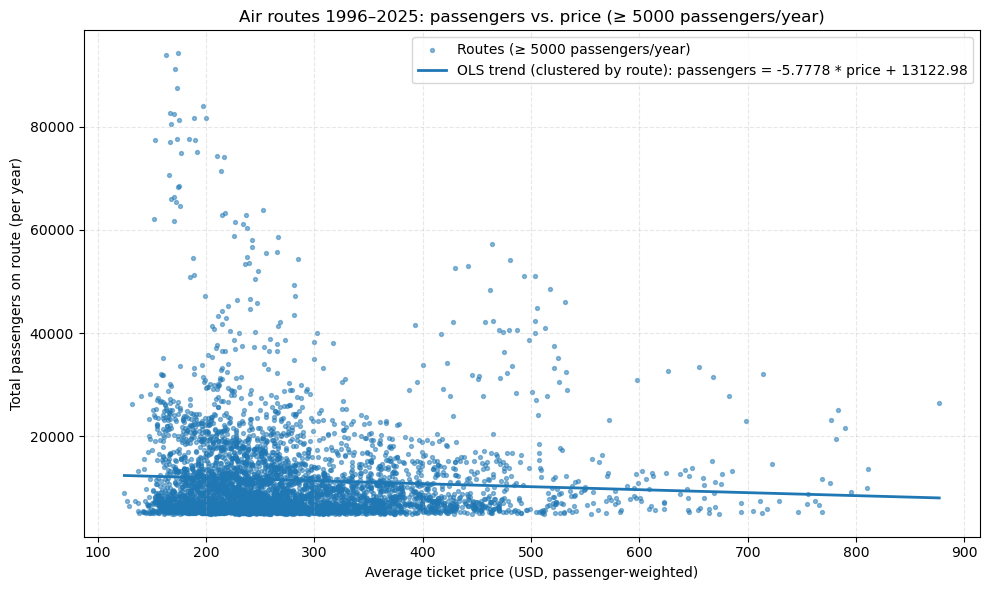

[PLOT] saved → outputs/figures_simple_reg/routes_cities_price_x.png


In [27]:
%run scr/simple_regression.py



[INFO] Chargement de data/merged_air_travel_data.csv ...
[INFO] Données nettoyées: 118035 lignes.

[INFO] Construction du panel états (state → city → year) ...


/Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/scr/elasticity_simple_reg.py:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


[INFO] Panel agrégé états → villes prêt : 24932 lignes.

[STATES] Elasticity (states → cities → year)

[INFO] Using clustered standard errors (groups = route_id)

=== [STATES] OLS log–log (raw) ===
                            OLS Regression Results                            
Dep. Variable:                 ln_pax   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.6920
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.406
Time:                        17:56:10   Log-Likelihood:                -4500.2
No. Observations:                5044   AIC:                             9004.
Df Residuals:                    5042   BIC:                             9018.
Df Model:                           1                                         
Covariance Type:              cluster                                         
            

<Figure size 640x480 with 0 Axes>

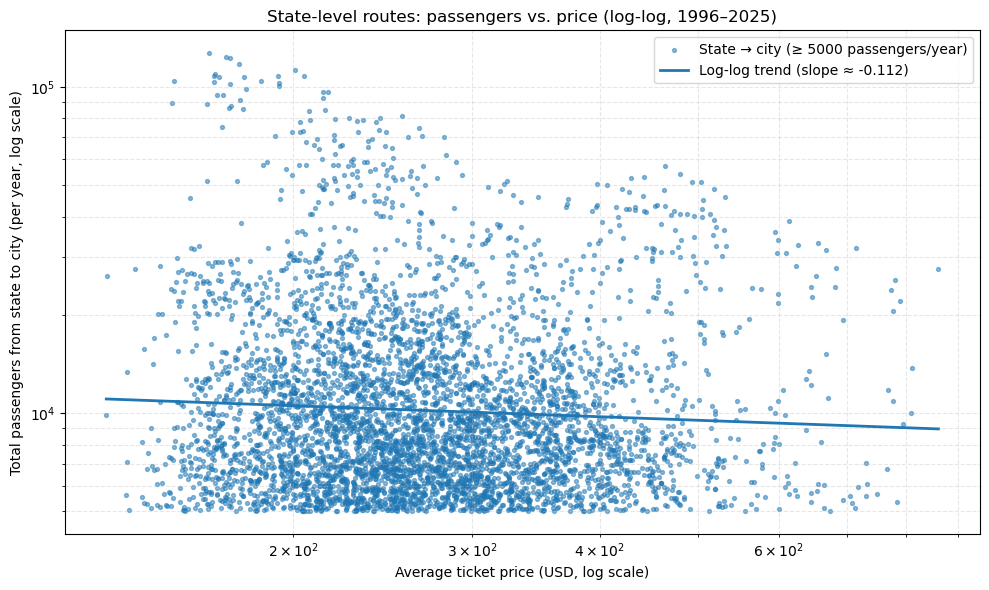

[STATES][PLOT] Saved: outputs/routes_states_loglog_price_x.png

[CITIES] Elasticity (city1 → city2 → year)

[INFO] Using clustered standard errors (groups = route_id)

=== [CITIES] OLS log–log (cities, cross-section) ===
                            OLS Regression Results                            
Dep. Variable:                 ln_pax   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.114
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.292
Time:                        17:56:15   Log-Likelihood:                -3675.1
No. Observations:                4586   AIC:                             7354.
Df Residuals:                    4584   BIC:                             7367.
Df Model:                           1                                         
Covariance Type:              cluster                               

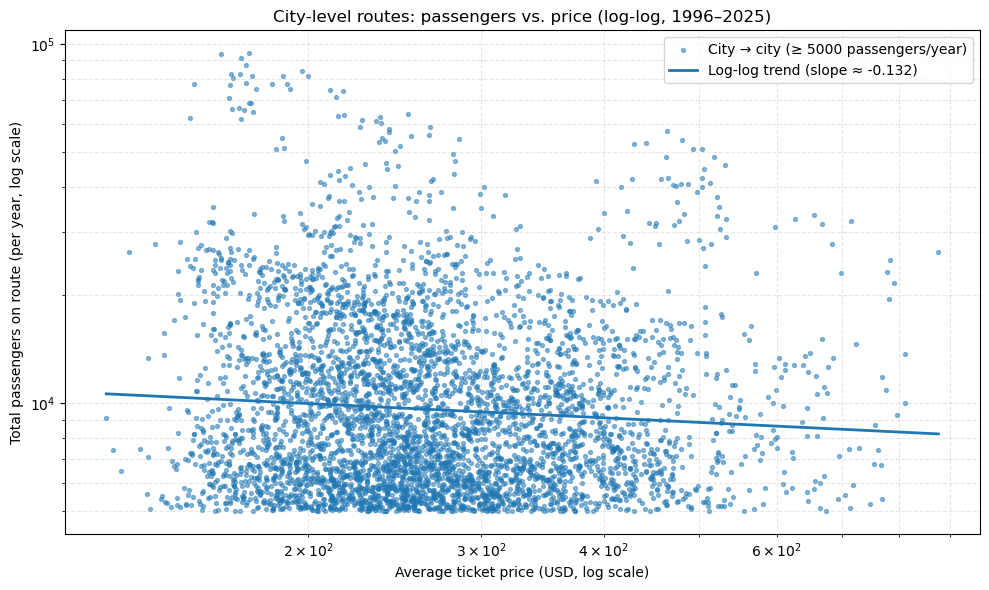

[CITIES][PLOT] Saved: outputs/routes_cities_loglog_price_x.png


In [28]:
%run scr/elasticity_simple_reg.py


In [19]:
from pathlib import Path
print("CWD:", Path.cwd())
print("Exists?", (Path("scr")/"endogeneity_from_merged.py").exists())
print("Files in scr:", [p.name for p in Path("scr").glob("*.py")])


CWD: /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook
Exists? False
Files in scr: ['elasticity_reg_w_FE.py', 'Reverse_causality.py', 'Reverse_Causality_spec_curve.py', 'Litterature_technics_tax.py', 'Data_cleaning.py', 'Reverse_Causality _w_FE.py', 'endogeneity.py', 'elasticity_simple_reg.py', 'States_advanced_causal.py', 'simple_regression.py']



[INFO] Chargement du panel measuring cities depuis data/merged_air_travel_data.csv ...

[INFO] Agrégation annuelle (origin, destination, Year) ...

[INFO] Panel villes prêt : 29118 observations.

[INFO] Élasticité simple pour routes (villes): log_passengers ~ log_price
                            OLS Regression Results                            
Dep. Variable:         log_passengers   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.4003
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.527
Time:                        18:05:11   Log-Likelihood:                -36324.
No. Observations:               29118   AIC:                         7.265e+04
Df Residuals:                   29116   BIC:                         7.267e+04
Df Model:                           1                                         
Covariance Type:  

/Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/scr/endogeneity.py:190: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if "Real price" not in df.columns:



[INFO] Panel agrégé états → villes prêt : 24932 lignes.

[INFO] Panel états prêt : 24932 observations.

[INFO] Descriptives par état-destination ...

[INFO] Descriptives par état (agrégées sur toutes les destinations) ...

[INFO] Plot mean price vs mean passengers par état ...

[INFO] Figure sauvegardée : outputs/figures_endogeneity/mean_price_vs_pax_by_state.png


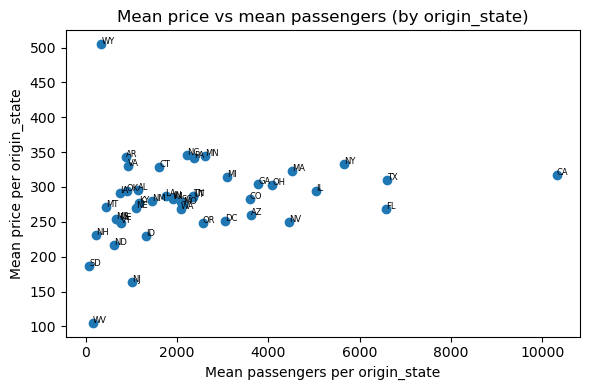


[INFO] Élasticité simple pour états -> destinations: log_passengers ~ log_price
                            OLS Regression Results                            
Dep. Variable:         log_passengers   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     9.649
Date:                Fri, 12 Dec 2025   Prob (F-statistic):            0.00194
Time:                        18:05:15   Log-Likelihood:                -40602.
No. Observations:               24932   AIC:                         8.121e+04
Df Residuals:                   24930   BIC:                         8.122e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [34]:
%run scr/endogeneity.py


In [33]:
%run scr/Reverse_Causality _w_FE.py



[INFO] Chargement des données trimestrielles (villes) depuis data/merged_air_travel_data.csv ...

[INFO] Agrégation au niveau annuel (city1, city2, Year) ...

[INFO] Panel villes prêt : 27305 observations avec lag de prix dispo.

[INFO] Saved prepared city panel: outputs/results_reverse_causality/panel_cities_lag.csv

[INFO] OLS lag model pour villes (city1 -> city2, annuel) : ln_pax_t ~ ln_price_lag1

[INFO] SE clusterisées sur route_id
                            OLS Regression Results                            
Dep. Variable:                 ln_pax   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.333
Date:                Fri, 12 Dec 2025   Prob (F-statistic):             0.0211
Time:                        17:58:10   Log-Likelihood:                -32897.
No. Observations:               27305   AIC:                         6.580e+04
Df R

/Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/scr/Reverse_Causality.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({



[INFO] Panel agrégé états → villes prêt : 24932 lignes.

[INFO] Panel états prêt : 23682 observations avec lag de prix dispo.

[INFO] Saved prepared state panel: outputs/results_reverse_causality/panel_states_lag.csv

[INFO] OLS lag model pour états (origin_state -> city2, annuel) : ln_pax_t ~ ln_price_lag1

[INFO] SE clusterisées sur route_id
                            OLS Regression Results                            
Dep. Variable:                 ln_pax   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     14.42
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           0.000154
Time:                        17:58:14   Log-Likelihood:                -38008.
No. Observations:               23682   AIC:                         7.602e+04
Df Residuals:                   23680   BIC:                         7.604e+04
Df Model:            

<Figure size 640x480 with 0 Axes>